<img src="https://github.com/thesps/conifer/blob/master/conifer_v1.png?raw=true" width="250" alt="conifer" />

In this notebook we will learn how to build coprocessor images for BDTs with `conifer` using the model from `part_1`.

We'll target Xilinx the Alveo U50 card.

<img src="https://www.xilinx.com/content/dam/xilinx/imgs/kits/U50_Hero_1_Bracket.png" width=250 alt="U50" />

In [1]:
from sklearn.datasets import make_moons
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
import conifer
import json
import os
import sys
import xgboost as xgb

# enable more output from conifer
import logging
logging.basicConfig(stream=sys.stdout, level=logging.WARNING)
logger = logging.getLogger('conifer')
logger.setLevel('DEBUG')

# create a random seed at we use to make the results repeatable
seed = int('fpga_tutorial'.encode('utf-8').hex(), 16) % 2**31

Could not import conifer tf_df converter
/home/sioni/miniconda3/envs/conifer-1.4/lib/python3.8/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/home/sioni/miniconda3/envs/conifer-1.4/lib/python3.8/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


## Register U50

Firstly create and register the configuration of the Alveo U50 board that we will use. The part number and platform are board/system specific descriptions of the hardware.

In [ ]:
u50 = conifer.backends.boards.AlveoConfig.default_config()
u50['xilinx_part'] = 'xcu50-fsvh2104-2-e'
u50['platform'] = 'xilinx_u50_gen3x16_xdma_5_202210_1'
u50['name'] = 'xilinx_u50_gen3x16_xdma_5_202210_1'
u50 = conifer.backends.boards.AlveoConfig(u50)
conifer.backends.boards.register_board_config(u50.name, u50)
conifer.backends.boards.get_available_boards()

# Accelerator Configuration
Now that we've registered the board, we can use it as an accelerator target. To do that, we need to provide the `AcceleratorConfig` section that we previously left blank. This will add AXI interfaces to the data ports that we can then use to write and read data from the host. With this flow, since we're still selecting the `xilinxhls` backend, we will build a _static_ accelerator. This produces a bitfile that is specific to the single model we converted.

In [ ]:
cfg = conifer.backends.xilinxhls.auto_config()

# print the config
print('Default Configuration\n' + '-' * 50)
print(json.dumps(cfg, indent=2))
print('-' * 50)

# modify the config
accel_cfg = {'Board'         : 'xilinx_u200_gen3x16_xdma_2_202110_1',
             'InterfaceType' : 'float',}
cfg['AcceleratorConfig'] = accel_cfg
cfg['OutputDir'] = 'prj_conifer_part_2_u200'

# print the config again
print('Modified Configuration\n' + '-' * 50)
print(json.dumps(cfg, indent=2))
print('-' * 50)

## Load model
Load the model that we trained and saved in part 1, applying the new configuration described above

In [ ]:
conifer_model = conifer.model.load_model('prj_conifer_part_1/my_prj.json', new_config=cfg)

## Build Static Accelerator

Build the static accelerator binary.

Firstly we run HLS C Synthesis. The result will be different to what we did in `part_1` since we've added the AXI interface that will introduce some overhead. At this point we export a `.xo` file that can be *linked* in the second step.

Secondly we run Vitis (with `v++`) to build the bitfile which synthesizes all the necessary components, and runs place & route. Finally we obtain a `.xclbin` file that we can load to the FPGA.

**Warning** the second part of this build will take around one hour to complete. When the message `Building Alveo bitfile ...` is displayed, check the file `vitis_build.log` for progress.

In [ ]:
conifer_model.write()
conifer_model.build(synth=True, bitfile=True)

## Result

By default the Vivado project is removed after the `v++` step. If we instead build with `conifer_model.build(synth=True, bitfile=True, build_opts='--save-temps')`, we can view the floorplan. Here's an example of what that looks like, with the BDT model highlighted in green near the lower left. The orange section is the 'static region' that is reserved for the platform functions.

<img src="images/conifer_hls_u50.png" width=500 />

## Runtime
Load the binary onto the Alveo card using the conifer runtime. It is using Xilinx's `pynq` API that we already saw.
We use the `AlveoDriver` from `conifer`, providing:
- the `.xclbin` file that we built in the previous steps
- the name of the 'ip' of the accelerator (by default conifer searches for IPs with `'conifer'` in the name)
- the data batch size. This is used to allocate buffers for data transfer, and we can resize them later

We also load the model JSON with the `conifer` Python backend to get a reference for the predictions.

#### Detail

In the driver, `conifer` loads the `.xclbin` file like `overlay = pynq.Overlay(bitfile)`

Buffers are allocated with `pynq.allocate(shape, dtype)`. The shape has dimensions `(batch_size, n_features)`, and the `dtype` is the data type of the interface (not necessarily the same as the internal types).
Predictions are always made on a full batch, so setting the batch size correctly is important for performance. In the FPGA, predictions over the batch are sequential, but we will transfer the full batch data in one go.

The model binary itself stores some basic information about the model: the number of features and the number of classes that are used to define the buffer shape.


In [4]:
model_u50 = conifer.backends.xilinxhls.runtime.AlveoDriver('prj_conifer_part_2_u200/my_prj.xclbin', ip_name='my_prj_accelerator_1', batch_size=1)
model_py = conifer.model.load_model('prj_conifer_part_2/my_prj.json', new_config={'backend':'py','output_dir':'dummy','project_name':'dummy'})

DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 3, "n_trees": 20, "n_features": 2, "n_classes": 2}


### Load data
Load the test data from the model dataset. *Note* we need to make sure the data type matches the accelerator interface type (which is `float`), so we cast to `float32`. Otherwise, the prediction step will throw an error.
We also set the batch size to resize the buffers, taking the first dimension of the data as the batch size: i.e. we will run prediction on the full data in one go.

In [5]:
X_test = np.load('moons_dataset/X_test.npy').astype('float32')
model_u50._init_buffers(batch_size=X_test.shape[0])

### Make predictions

Run inference on both the Alveo card and the Python model on CPU!

#### Detail
After checking data type and shape compatibility, the inference is executed on data `X` by the driver like:

```
Xbuf[:] = X                                               # copy the data into the buffer
Xbuf.sync_to_device()                                     # transfer the buffer host->card
ip.call(batch_size, null_buffer, null_buffer, Xbuf, ybuf) # call the accelerator
while not ip.register_map.CTRL.AP_IDLE:                   # wait for the accelator to finish by polling the 'idle' status bit
  pass
ybuf.sync_from_device()                                   # transfer the buffer card->host
```

In [6]:
y_u50 = model_u50.decision_function(X_test)
y_py = model_py.decision_function(X_test)

# Exercise
Make some measurements of the time it takes to make predictions for the different methods. Use `time.perf_counter` or the `%%timeit` magic.

Use the `xgboost` model rather than the `conifer` Python evaluation for the CPU reference. You can load it like:
```
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('prj_conifer_part_1/xgboost_model.json')
```

Try changing the batch size to see how that impacts the performance.

Make a plot with batch size on the x axis and computation time on the y axis.

To make more data for inference timing you can make some random numbers (for example with `np.random.rand`), generate a grid like in part 1 with more fine sampling, or use the `make_moons` method again with more samples.

In [9]:
import time
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('prj_conifer_part_1/xgboost_model.json')

In [16]:
n_per_batch = 10
batches = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
time_u200 = np.zeros_like(batches, dtype='float')
time_xgb = np.zeros_like(batches, dtype='float')

for i in range(10):
    xgb_model.predict_proba(X_test[:10])

for i, batch in enumerate(batches):
    Xi = X_test[:batch]
    model_u50 = conifer.backends.xilinxhls.runtime.AlveoDriver('prj_conifer_part_2_u200/my_prj.xclbin', ip_name='my_prj_accelerator_1', batch_size=batch)

    for j in range(n_per_batch):
        start = time.perf_counter()
        y_u200 = model_u50.decision_function(Xi)
        stop = time.perf_counter()
        time_u200[i] += (stop - start)
    
        start = time.perf_counter()
        y_xgb = xgb_model.predict_proba(Xi)
        stop = time.perf_counter()
        time_xgb[i] += (stop - start)
time_u200 /= n_per_batch
time_xgb /= n_per_batch

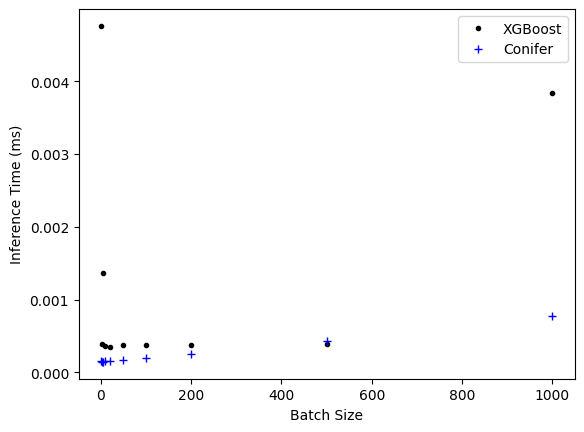

In [17]:
plt.plot(batches, time_xgb, '.k', label='XGBoost')
plt.plot(batches, time_u200, '+b', label='Conifer')
plt.xlabel('Batch Size')
plt.ylabel('Inference Time (ms)')
plt.legend()